In [1]:
import torch

print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scipy==1.1

     |████████████████████████████████| 31.2MB 108kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [4]:
! cp drive/MyDrive/facades_tar.gz /content

In [5]:
!ls /content

drive  facades_tar.gz  sample_data


In [7]:
!tar -xf facades_tar.gz

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import time
import torch.nn.functional as F
import warnings
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.autograd import Variable
from IPython.display import clear_output

from tools import (data_load,
                   imgs_resize,
                   random_crop,
                   random_fliplr,
                   show_train_hist,
                   show_results,
                   train_routine,
                   inference,
                  )
from gan_net import (Generator,
                     Discriminator,
                    )

warnings.filterwarnings('ignore')

___

Параметры

In [10]:
dataset = 'facades'
save_root = 'results'
train_subfolder = 'train'
test_subfolder ='val'

batch_size = 3
test_batch_size = 1

ngf = 64
ndf = 64

input_size = 256
crop_size = 256
resize_scale = 286

train_epoch = 150

___

In [11]:
if not os.path.isdir(dataset + '_' + save_root + '/'):
    os.mkdir(dataset + '_' + save_root + '/')

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                               ],
                              )

train_loader = data_load(dataset,train_subfolder,transform,batch_size,shuffle=True)

test_loader = data_load(dataset,test_subfolder,transform,test_batch_size,shuffle=False)

test = test_loader.__iter__().__next__()[0]
img_size = test.size()[2]

fixed_y_ = test[:, :, :, 0:img_size]
fixed_x_ = test[:, :, :, img_size:]
    
if img_size != input_size:
    fixed_x_ = imgs_resize(fixed_x_, input_size)
    fixed_y_ = imgs_resize(fixed_y_, input_size)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [14]:
G = Generator(ngf)
G.to(device)
G.train();

D = Discriminator(ndf)
D.to(device)
D.train();

In [15]:
BCE_loss = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))

Epoch [150/150]


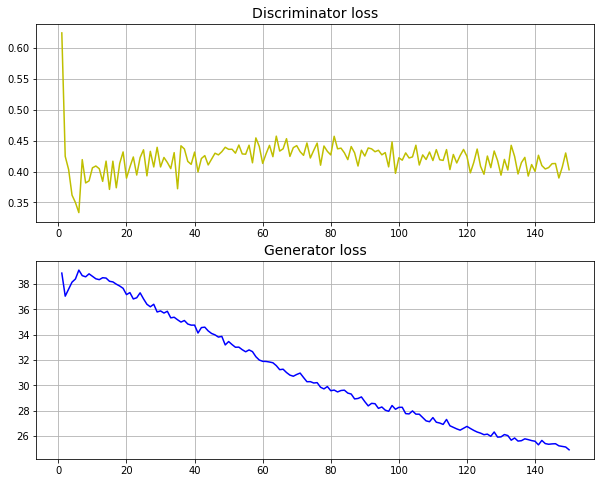

In [16]:
train_routine(train_epoch, train_loader, img_size, input_size, resize_scale, crop_size,
                  random_fliplr, device, BCE_loss, L1_loss, G_optimizer, D_optimizer, D, G)

___

In [17]:
G.to(device)
G.eval();

In [18]:
if not os.path.isdir(dataset + '_results/test_results'):
    os.mkdir(dataset + '_results/test_results')

In [19]:
inference(test_loader, device, G, dataset, input_size)

# Результаты

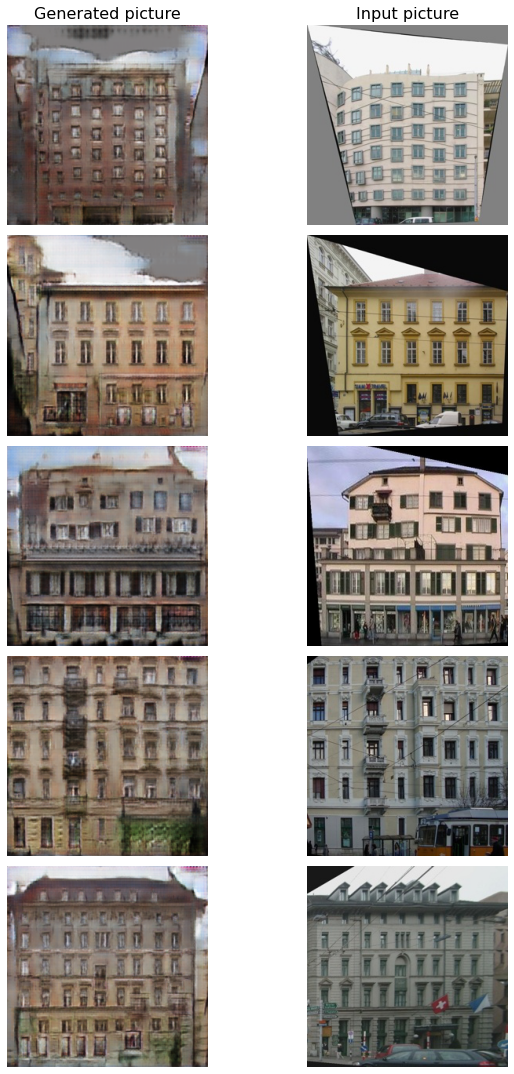

In [20]:
show_results(n_pic=5)

150 эпох вроде хватило для адекватного генерирования